In [26]:
# =============================
# Imports & Setup
# =============================
from numpy.random import seed
seed(40)

import tensorflow as tf
tf.random.set_seed(40)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from transformers import TFAutoModel, AutoTokenizer

print("TensorFlow version:", tf.__version__)
print("Transformers version:", tf.__version__)

TensorFlow version: 2.19.0
Transformers version: 2.19.0


In [27]:
# =============================
# Configuration
# =============================
EPOCHS = 3
BATCH_SIZE = 32
MAX_LEN = 96
MODEL_NAME = 'bert-base-multilingual-cased'
AUTO = tf.data.experimental.AUTOTUNE

In [28]:

# =============================
# Load and Prepare Data
# =============================
print("Loading datasets...")

train_data = pd.read_csv('../Dataset/train.csv')
validation_data = pd.read_csv('../Dataset/validation.csv')
df_content_language = pd.read_csv('../Dataset/test.csv')
df_toxicity = pd.read_csv('../Dataset/test_labels.csv')

# Merge test datasets on the 'id' column
test_data = pd.merge(df_content_language, df_toxicity, on='id')

Loading datasets...


In [29]:
train_data['toxics'] = train_data[['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']].sum(axis=1) > 0
train_data['toxics'] = train_data['toxics'].astype(int)
train_data.drop(columns=['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry'], inplace=True)

train_data = train_data.rename(columns={'toxics': 'toxic'})
test_data = test_data.rename(columns={'content': 'feedback_text'})

text_column = 'feedback_text'
label_column = 'toxic'

In [30]:
# =============================
# Tokenizer and Dataset Prep
# =============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_text(texts, max_length=96):
    texts = [str(text) if pd.notna(text) else "" for text in texts]
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=False
    )

In [31]:
def create_dataset(texts, labels=None, batch_size=16, is_training=False):
    encodings = encode_text(texts, MAX_LEN)
    inputs = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }

    if labels is not None:
        dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if is_training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size).prefetch(AUTO)

In [32]:
print("Creating datasets...")
train_dataset = create_dataset(train_data[text_column], train_data[label_column], BATCH_SIZE, is_training=True)
validation_dataset = create_dataset(validation_data[text_column], validation_data[label_column], BATCH_SIZE)
test_dataset = create_dataset(test_data[text_column], test_data[label_column], BATCH_SIZE)

Creating datasets...


In [33]:
# =============================
# Model Building (Custom Head)
# =============================
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel

def build_model(transformer_model, max_len=96):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Define a Lambda layer with output shape manually set
    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        outputs = transformer_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

    cls_output = Lambda(
        extract_cls_token,
        output_shape=(transformer_model.config.hidden_size,)
    )([input_ids, attention_mask])

    output = Dense(1, activation='sigmoid')(cls_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model


In [34]:
print("Building model...")
# Assuming 'strategy' is already defined and 'MODEL_NAME' is set
from transformers import TFAutoModel

with strategy.scope():
    transformer = TFAutoModel.from_pretrained(MODEL_NAME)
    model = build_model(transformer_model=transformer, max_len=MAX_LEN)
model.summary()

Building model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        769 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# =============================
# Callbacks & Training
# =============================
callbacks = [
    EarlyStopping(monitor='val_auc', patience=2, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True, mode='max')
]

print("Training model...")
steps_per_epoch = len(train_data) // BATCH_SIZE
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks
)

Training model...
Epoch 1/3
733/733 ━━━━━━━━━━━━━━━━━━━━ 2759s 4s/step - accuracy: 0.8458 - auc_2: 0.4714 - loss: 0.5437 - val_accuracy: 0.8405 - val_auc_2: 0.4509 - val_loss: 0.4673
Epoch 2/3


/home/promit/Offensive-Language-Classification/.venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_2,loss,val_accuracy,val_auc_2,val_loss
  current = self.get_monitor_value(logs)
/home/promit/Offensive-Language-Classification/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


733/733 ━━━━━━━━━━━━━━━━━━━━ 3162s 4s/step - accuracy: 0.9003 - auc_2: 0.4977 - loss: 0.3926 - val_accuracy: 0.8405 - val_auc_2: 0.4773 - val_loss: 0.4485
Epoch 3/3
733/733 ━━━━━━━━━━━━━━━━━━━━ 3164s 4s/step - accuracy: 0.9002 - auc_2: 0.5560 - loss: 0.3434 - val_accuracy: 0.8405 - val_auc_2: 0.5088 - val_loss: 0.4481


In [36]:
# =============================
# Evaluation
# =============================
print("Evaluating model...")
loss, accuracy, auc = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


Evaluating model...
188/188 ━━━━━━━━━━━━━━━━━━━━ 827s 4s/step - accuracy: 0.7701 - auc_2: 0.5568 - loss: 0.5695
Test Loss: 0.5650
Test Accuracy: 0.7728
Test AUC: 0.5481


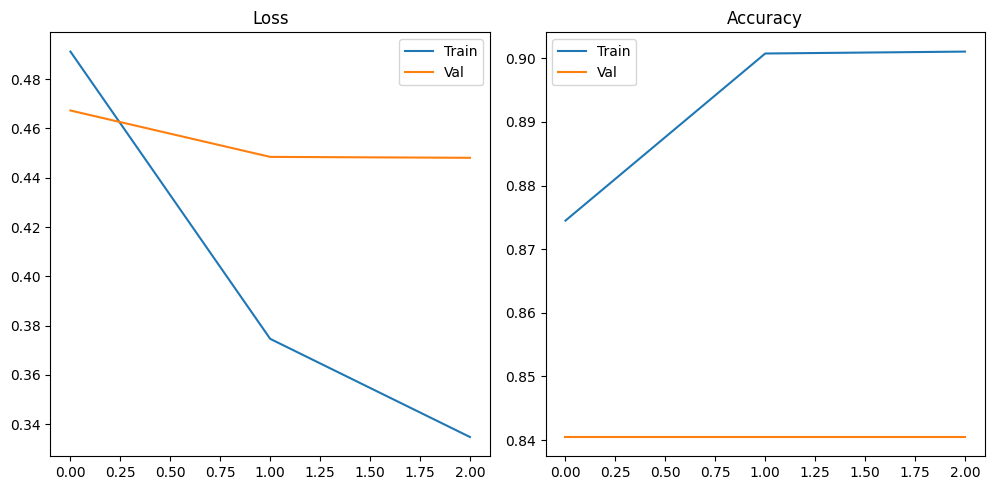

Generating predictions...
188/188 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step
Predictions saved to 'test_predictions.csv'


ValueError: The filename must end in `.weights.h5`. Received: filepath=toxic_classifier_weights.h5

In [38]:
# =============================
# Plot Training Metrics
# =============================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()


plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# =============================
# Predictions & Save
# =============================
print("Generating predictions...")
predictions = model.predict(test_dataset).flatten()

results_df = pd.DataFrame({
    'id': test_data['id'],
    'predicted_toxic': predictions,
    'actual_toxic': test_data[label_column]
})

results_df.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'")

model.save_weights('toxic_classifier_weights.h5')
print("Model weights saved to 'toxic_classifier_weights.h5'")
